In [1]:
import numpy as np
import timeit
import matplotlib.pyplot as plt
import scipy.sparse.linalg as spsl
from scipy.sparse import csc_matrix
rng = np.random.default_rng(12345)
from IPython.display import Image
%matplotlib inline

# Circuit diagrams

Below is a simple example of a circuit diagram: a representation of a real electrical circuit. When analyzing circuits, we care about the **voltage** (electrical pressure difference) across a component, and the **current** (electrical flow) through a component.

![title](general_ckt.png)

(Illustration from Hayt/Kemmerly p. 255.)

A sharp squiggly line is a **resistor**, a loopy line is an **inductor**, and a pair of short parallel lines are a **capacitor**. Each component has a physical coefficient which determines its behavior when subjected to a current or a voltage: resistors have resistance $R$, inductors have inductance $L$, and capacitors have capacitance $C$.

When analyzing frequency response - for, e.g., an audio amplifier - each component is characterized by its **admittance** $Y$, which depends on the (here, time-invariant) frequency $s$ of the signal (usually voltage) it receives. Resistors have admittance $Y_{R} = 1/R$, inductors have admittance $Y_{L} = \frac{1}{sL}$, and capacitors have admittance $Y_{C} =  sC$, where $s = j \omega$ is an imaginary number. For any of these components, the relationship between the voltage across it and the current through it is given by Ohm's law:

$$ VY = I $$

where $V$ and $I$ are sinusoidal signals of time-invariant frequency and amplitude.

# Setting up a matrix: the nodal formulation

Note that the circuit elements in the diagram above are connected at **nodes**. Kirchhoff's current law says that whatever current flows into a node must also flow out of the node. With this, and a couple other mathematical tricks, we can formulate a matrix equation of a familiar form.

Consider a circuit diagram which has $n + 1$ nodes, where one node is defined to have potential 0. Then the behavior of this circuit is characterized by a matrix equation of the form

$$ YV = J $$

where $Y \in \mathbb{C}^{n \times n}$, $V \in \mathbb{C}^{n \times 1}$, and $J \in \mathbb{C}^{n \times 1}$. 

$Y$ is called the admittance matrix, where $y_{ab}$ is equal to the opposite of the admittance between nodes $a$ and $b$, $a\neq b$. If there is no component between nodes $a$ and $b$, $y_{ab} = 0$. For $a=b$, $y_{aa}$ is the sum of the admittances connected to node $a$.

$V$ is the voltage vector, where $v_{a}$ is the voltage (with respect to ground) at node $a$. 

$J$ is the source vector, where $j_{a}$ is the sum of the currents from sources entering node $a$. (It can be shown that all voltage and current sources can be reformulated to fit into $J$.)

At this point, the procedure is probably pretty clear: we want to solve for $V$ efficiently, so use Gaussian elimination with partial pivoting (about $n^{3}/3$ flops) and substitution. It's definitely better than finding the inverse, right?

Yes, but it's not the best in this case.

# Sparsity

The admittance matrix $Y$ is what we call **sparse**: that is, lots of its entries are zero. This is because, in real applications, any node is unlikely to be connected to a lot of other nodes. When $LU$-decomposing a sparse matrix, lots of operations are multiplying by zero or adding or subtracting zero. These operations are, in a sense, wasted. In fact, we don't even need to store the zeros at all.

This leads to significant savings. According to Vlach & Singhal, "In a typical large electrical network, the number of components ranges from two to four times the number of nodes... for such networks, the total number of nonzeros in the matrix is a small fraction of $n^{2}$, the total number of entries in the matrix." The computational cost of sparse $LU$ algorithms "grows approximately linearly with size $n$, compared to $n^{3}/3$ for dense matrices." (60)

In other words, sparse matrix methods are very useful in analyzing especially large circuits. But since we didn't cover much about sparsity in class, I'll just use and compare sparse methods, rather than explaining them.

# Example: Phase-splitter

(Example and figures taken from Vlach-Singhal p. 62.)

![title](phase_splitter.png)

This circuit has 17 nodes and a ground node (0), with input node (1) and output nodes (5) and (13). Its full (dense) 17x17 admittance matrix is defined below, with resistances in ohms, inductances measured in millihenrys, and capacitors in millifarads.

In [2]:
s = 2*np.pi*60j # s is the frequency in the Laplace domain

# Define component values:
L1=L2=C1=C2 = 0.102888
L3=L4=C3=C4 = 0.493852
L5=L6=C5=C6 = 2.15717
L7=L8=C7=C8 = 17.2722
L9=L10=C9=C10 = 0.0293307
L11=L12=C11=C12 = 4.87647
L13=L14=C13=C14 = 1.02583
L15=L16=C15=C16 = 0.234847
R1=R2=R3 = float(1)

# Define source matrix:
J = np.zeros(17)
J[0] = 1

# Define admittance matrix in terms of components:
def Y_PhaseSplitterHalfDense(s): # Given a frequency s, return the half-dense admittance matrix of the phase splitter

    return np.array([
                [1/(s*L1)+s*C1+1/(s*L9)+s*C9,-1/(s*L1),0,0,0,0,0,0,-s*C1,-1/(s*L9),0,0,0,0,0,0,-s*C9],
                [0,1/(s*L1)+s*C2+s*C3+1/(s*L3),-1/(s*L3),0,0,0,0,-s*C3,0,0,0,0,0,0,0,0,0],
                [0,0,1/(s*L3)+s*C4+s*C5+1/(s*L5),0,0,-s*C5,0,-s*C4,0,0,0,0,0,0,0,0,0],
                [0,0,0,1/(s*L5)+s*C6+s*C7+1/(s*L7),-1/(s*L7),-s*C7,0,-s*C6,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,1/(s*L7)+s*C8+1/R2,-1/R2,-s*C8,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,1/(s*L8)+s*C7+1/R2,-1/(s*L8),0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,1/(s*L6)+s*C5+s*C8+1/(s*L8),-1/(s*L6),0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,1/(s*L4)+s*C3+s*C6+1/(s*L6),-1/(s*L4),0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,1/(s*L2)+s*C1+s*C4+1/(s*L4),0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,1/(s*L9)+s*C10+s*C11+1/(s*L11),-1/(s*L11),0,0,0,0,s*C11,0],
                [0,0,0,0,0,0,0,0,0,0,1/(s*L11)+s*C12+s*C13+1/(s*L13),-1/(s*L13),0,0,-s*C13,0,-s*C12],
                [0,0,0,0,0,0,0,0,0,0,0,1/(s*L13)+s*C14+s*C15+1/(s*L15),-1/(s*L15),-s*C15,0,-s*C14,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,1/(s*L15)+s*C16+1/R3,-1/R3,-s*C6,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,1/(s*L16)+s*C15+1/R3,-1/(s*L16),0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/(s*L14)+s*C13+s*C16+1/(s*L16),-1/(s*L14),0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/(s*L12)+s*C11+s*C14+1/(s*L14),-1/(s*L12)],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1/(s*L10)+s*C9+s*C12+1/(s*L12)]])

def ACSweep_HalfDense(StartFrequency, EndFrequency, PartitionsAmount, J, nodes, Y):
    # Given bandwidth in Hertz, solve for a specifc node voltage over a bunch of frequencies
    # Y should be a function that gives a half-dense admittance matrix
    LaplaceStartFrequency = 2*np.pi*StartFrequency*1j
    LaplaceEndFrequency = 2*np.pi*EndFrequency*1j
    LaplaceInterval = (LaplaceEndFrequency-LaplaceStartFrequency)/PartitionsAmount
    
    i=0
    Sweep = np.zeros(((PartitionsAmount+1),nodes),dtype=complex)
    while i<= PartitionsAmount:
        Y_full = Y(LaplaceStartFrequency+i*LaplaceInterval)
        Y_full = Y_full + Y_full.T - np.diagonal(Y_full)
        Sweep[i] = np.linalg.solve(Y_full, J)
        i=i+1
    
    return Sweep

def ACSweep_HalfDense_Sparse(StartFrequency, EndFrequency, PartitionsAmount, J, nodes, Y):
    # Largely the same as above, but using SciPy's sparse solver instead
    LaplaceStartFrequency = 2*np.pi*StartFrequency*1j
    LaplaceEndFrequency = 2*np.pi*EndFrequency*1j
    LaplaceInterval = (LaplaceEndFrequency-LaplaceStartFrequency)/PartitionsAmount
    
    i=0
    Sweep = np.zeros(((PartitionsAmount+1),nodes),dtype=complex)
    while i<= PartitionsAmount:
        Y_full = Y(LaplaceStartFrequency+i*LaplaceInterval)
        Y_full = Y_full + Y_full.T - np.diagonal(Y_full)
        Y_full = csc_matrix(Y_full)
        Sweep[i] = spsl.spsolve(Y_full, J)
        i=i+1
    
    return Sweep

Ordinary LU solver time:
Wall time: 956 ms
Sparse LU solver time:
Wall time: 3.03 s


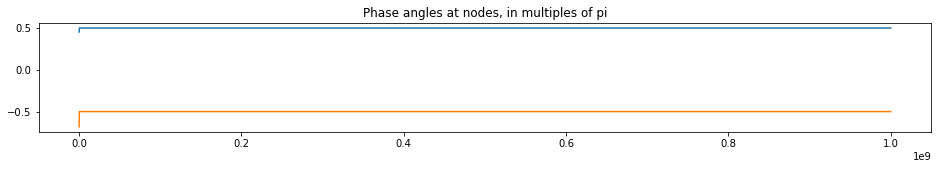

In [3]:
startFreqHz = 1
endFreqHz = 10**9
partitions = 10000

print("Ordinary LU solver time:")
%time PSSweep = ACSweep_HalfDense(startFreqHz,endFreqHz,partitions,J,17,Y_PhaseSplitterHalfDense)
print("Sparse LU solver time:")
%time PSSweep_Sparse = ACSweep_HalfDense_Sparse(startFreqHz,endFreqHz,partitions,J,17,Y_PhaseSplitterHalfDense)

fig=plt.figure(figsize=(16,2))
t=np.linspace(startFreqHz,endFreqHz,partitions+1)
plt.title("Phase angles at nodes, in multiples of pi")
plt.plot(t,np.angle(PSSweep[:,4])/np.pi)
plt.plot(t,np.angle(PSSweep[:,12])/np.pi)

This is pretty much the behavior we expect from a phase-splitter circuit.

It's clear that this is a small enough example that sparse methods harm rather than help, at least with this implementation. So let's take a look at a larger example, where sparse methods are much faster.

# Example: long transmission line

A wire carrying a signal is called a transmission line. Even though it seems to be just a simple copper wire, there are tiny resistances, capacitances, and inductances involved which govern the transmission of the signal. Therefore the wire is not an ideal "node"; voltages and currents may be different at different points along the wire, even at the same time.

We can model this with an equivalent lumped circuit for the transmission line. Let's model a transmission line of length $l$ by chopping it up into $k$ identical cells, each representing $\Delta z = k/l$ of the line:

![title](tl_cells.png)

(Illustration from Demarest, K. "Engineering Electromagnetics" p. 356.)

Each cell is itself a miniature circuit, composed of 6 nodes and 1 ground node. Let's say that at one end, we have a current source $I_{g}$, and on the other end we have a simple resistive load $R_{o}$.

![title](tl_line.png)

(Illustration from Demarest, K. "Engineering Electromagnetics" p. 365.)

So let's form an admittance matrix for our newly completed circuit:

In [7]:
# Define line length and number of cells:
l = 10**2
k = 10**4

# Define component values:
Ig = 1 + 1j
LL = LR = 0.1
RL = RR = R = 0.1
C = 0.1
Ro = 10000

# Define operating frequency s:
s = 60*2*np.pi*1j # 60 Hz, like your wall outlet

# Define admittance matrix:
Y = np.zeros((k+2,k+2),dtype=complex)
Y[0,0] = Y[0,1] = Y[1,0] = 1/(s*LL+RL) # node 1
Y[k+1,k+1] = 1/(s*LR+RR)+1/Ro # node k+2
for i in range(1,k+1):
    Y[i,i] = 1/(s*LL+RL)+1/(s*LR+RR)+1/R+s*C
    Y[i+1,i] = Y[i,i+1] = 1/(s*LL+RL) # LL = LR and RL = RR

But wait - in real life, admittances will vary along the wire due to kinks, twists, varying copper density, etc. So let's add in a little noise as well. (If this noise didn't exist, we could actually analyze the line analytically rather than numerically, but that's not the point of this course.) We'll add noise only to the nonzero entries of $Y$, because adding noise to the zero entries would be like creating a connection where there is none.

In [8]:
# Create a noise matrix A:
A = np.diag(rng.random((k+2))/10**6)           # main diagonal, real part
A = A + np.diag(rng.random((k+1))/10**6,k=1)       # +1 diagonal, real part
A = A + np.diag(rng.random((k+1))/10**6,k=-1)      # -1 diagonal, real part
A = A + np.diag(rng.random((k+2))*1j/10**6)    # main diagonal, imaginary part
A = A + np.diag(rng.random((k+1))*1j/10**6,k=1)    # +1 diagonal, imaginary part
A = A + np.diag(rng.random((k+1))*1j/10**6,k=-1)   # -1 diagonal, imaginary part

Y = Y + A

Now let's define the source matrix, and we'll be ready to solve the system.

In [9]:
J = np.zeros((k+2,1),dtype=complex)
J[0,0] = Ig

We'll try solving with dense methods first - it's gonna be slow...

In [10]:
print("Ordinary LU solver time:")
%time V_dense = np.linalg.solve(Y,J)

Ordinary LU solver time:
Wall time: 1min 15s


Now let's do it the sparse way - hopefully much faster.

In [11]:
Y_sparse = csc_matrix(Y) # store Y in sparse format
print("Sparse solver time:")
%time V_sparse = spsl.spsolve(Y_sparse,J)

Sparse solver time:
Wall time: 33.4 ms


So we took a large ($6k$-component) electrical network, and solved it via sparse methods in literally 0.1% the time of dense methods. This is something of a pathological case, but it illustrates sparse savings very well.


Sources used:

Jiri Vlach, Kishore Singhal. "Computer Methods for Circuit Analysis and Design." Van Nostrand Reinhold, 1994.

Kenneth Demarest. "Engineering Electromagnetics." Prentice Hall, 1998.

Adel Sedra, Kenneth Smith. "Microelectronic Circuits." Oxford University Press, 2015.

William Hayt, Jack Kemmerly, Steven Durbin. "Engineering Circuit Analysis". McGraw-Hill, 2012.